In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [2]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In [3]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
list('00000')
for binarystring in bitstrings:
    z = np.array(list(binarystring), dtype=int) # is a list of integer representing the current binary string
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


In [4]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    print(Q)
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.3

In [ ]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

array([[ 5.43591935,  1.83221016],
       [ 5.30433156, -6.2289737 ],
       [-1.57590666, -2.14702291],
       [ 1.61714433, 11.07433973],
       [15.37762057,  2.91043984]])

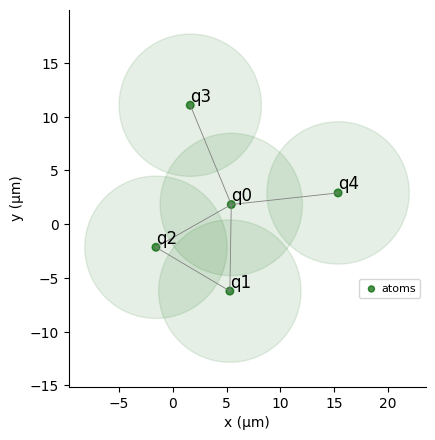

In [6]:
qubits = {'q0': np.array([5.43591935, 1.83221016]),
 'q1': np.array([ 5.30433156, -6.2289737 ]),
 'q2': np.array([-1.57590666, -2.14702291]),
 'q3': np.array([ 1.61714433, 11.07433973]),
 'q4': np.array([15.37762057,  2.91043984])}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [7]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)


for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [8]:
import time
def quantum_loop(parameters,disable_save=True):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ch0", "rydberg_global")

    t_list = seq.declare_variable("t_list", size=LAYERS)
    s_list = seq.declare_variable("s_list", size=LAYERS)


    for t, s in zip(t_list, s_list):
        pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
        pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

        seq.add(pulse_1, "ch0")
        seq.add(pulse_2, "ch0")

    seq.measure("ground-rydberg")
    
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    if disable_save == False:
        assigned_seq.draw()
        s_readable = assigned_seq.to_abstract_repr(
        json_dumps_options={"indent": 1},
        seq_name="qaoa_seq",
        )
        with open(f"qaoa2{time.time()}.json", "w") as f:
            f.write(s_readable)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [9]:
LAYERS = 2
np.random.seed(151)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}
# optimal_array = [[9.34167118, 2.27130768],
#  [8.57625465 ,2.70184433],
#  [8.46303954, 2.45161533],
#  [9.11268288 ,2.22450115],
#  [9.31664128, 2.447587  ],
#  [8.85598306, 1.64633822],
#  [9.97253034, 1.72514458],
#  [9.38000773, 1.45700094],
#  [8.97176167, 1.58918132],
#  [8.78742231, 2.26445045],
#  [8.68820589, 1.18535679],
#  [9.46854535, 1.86786162],
#  [9.1088774 , 1.8637817 ],
#  [8.12832316, 1.98956513],
#  [8.80580329, 1.85219168],
#  [9.48645651, 1.62631664],
#  [8.37422211, 1.85474882],
#  [8.36012661, 2.80727353],
#  [9.07311243 ,2.89151002],
#  [9.07366547, 2.0058863 ]]

# [[10.22251347,  2.49894049],
#  [ 9.2351566,   1.7927563 ],
#  [ 7.17415459,  3.10382428],
#  [ 8.54410561,  2.49094206]]
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])
example_dict


Counter({'00011': 215,
         '00101': 130,
         '00100': 115,
         '00000': 113,
         '01010': 113,
         '01000': 112,
         '10000': 62,
         '00010': 52,
         '00001': 52,
         '01011': 16,
         '00111': 12,
         '10001': 2,
         '01110': 2,
         '01101': 1,
         '01111': 1,
         '00110': 1,
         '10101': 1})

In [10]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

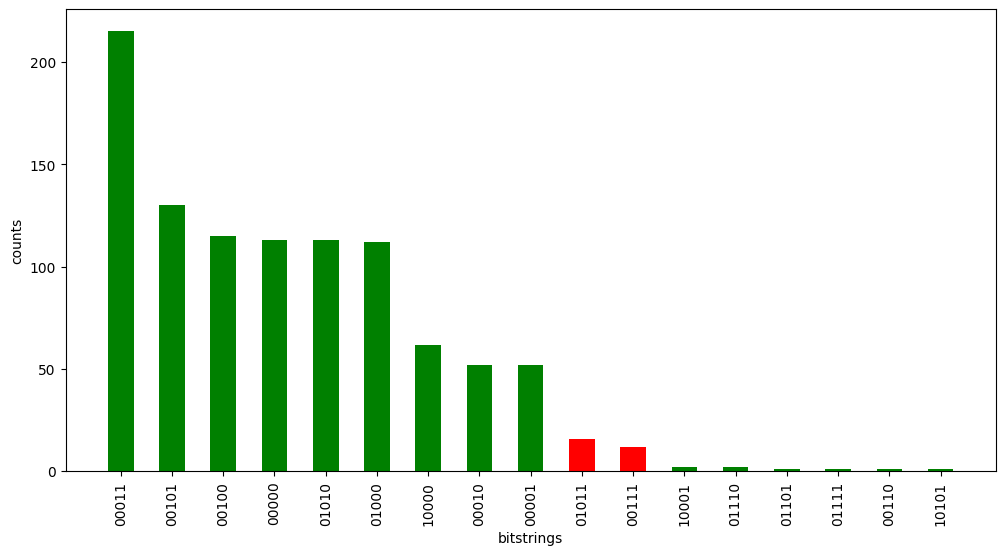

In [11]:
plot_distribution(example_dict)

In [12]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [13]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

In [14]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

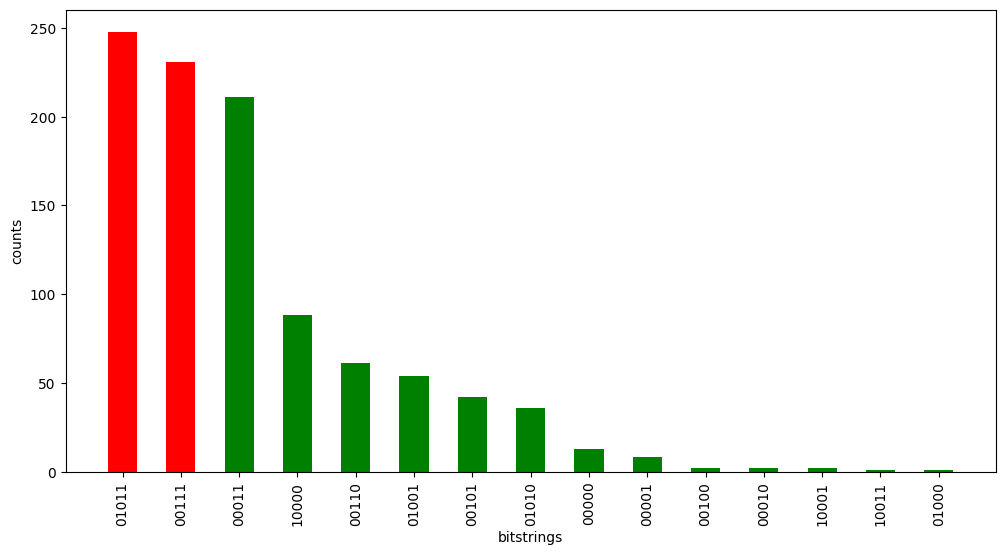

In [15]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

# Adiabatic

In [16]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

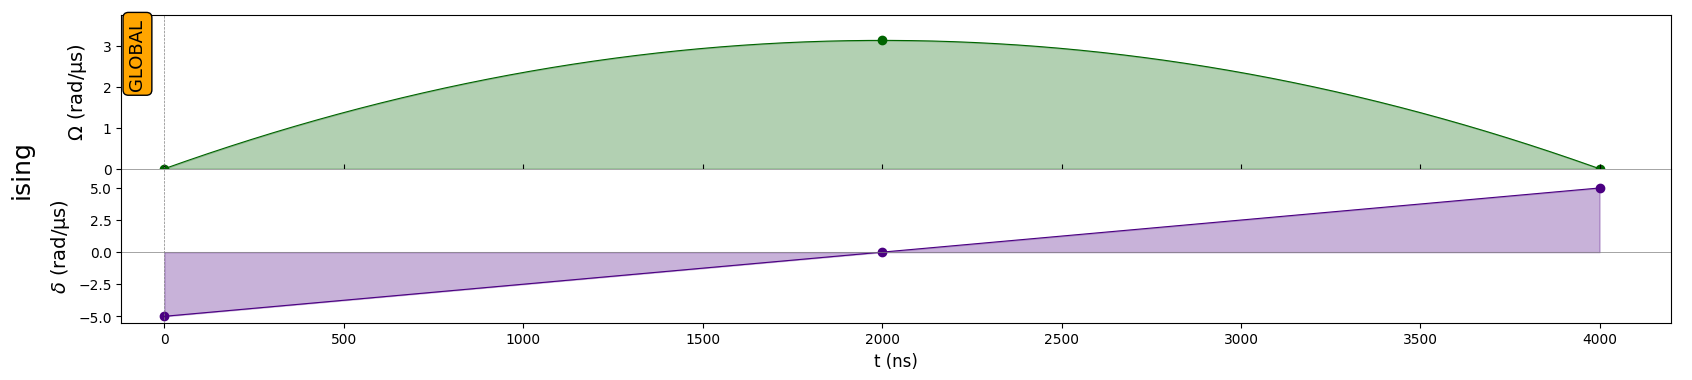

In [17]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [18]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

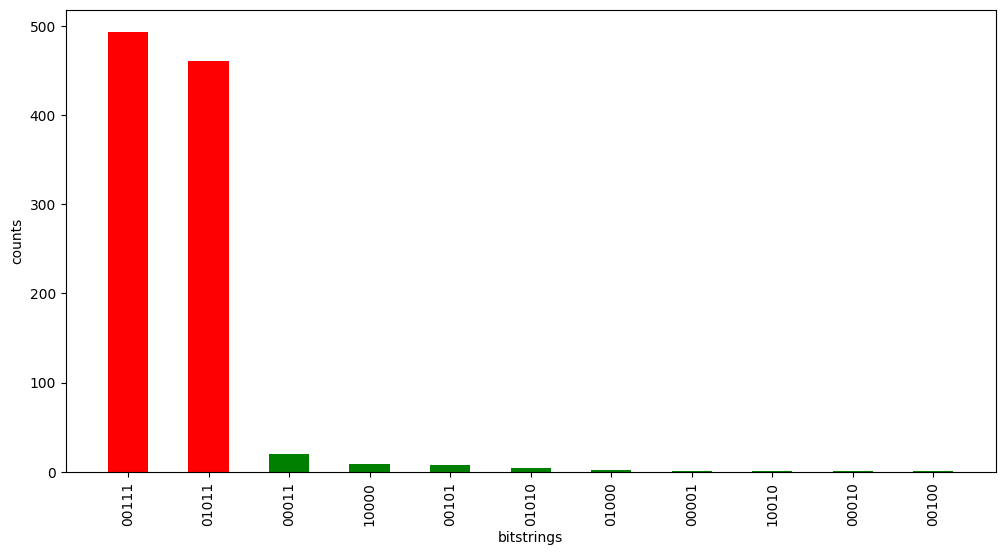

In [19]:
plot_distribution(count_dict)


[(0.75, 0.125), (0.625, 0.4955127018922193), (0.8125, 0.24775635094610965), (0.40625, 0.12387817547305482), (0.703125, 0.06193908773652741), (0.8515625, 0.030969543868263706), (0.42578125, 0.015484771934131853), (0.462890625, 0.44075508785928524), (0.7314453125, 0.22037754392964262), (0.432861328125, 0.48810708787463), (0.5, 0.8660254037844386)]


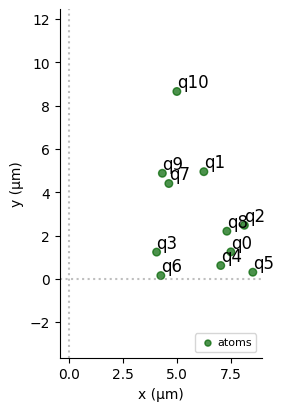

In [20]:
import math
import random
from typing import List, Tuple

# ──────────────────────────────────────────────────────────
#  Public helper
# ──────────────────────────────────────────────────────────
def generate_sierpinski_points(
    n: int,
    min_dist: float = 0.02,
    *,
    include_apex: bool = True,
    max_trials: int = 100_000,
) -> List[Tuple[float, float]]:
    """
    Generate up to 30 points that lie in the classic Sierpiński
    triangle (vertices at (0,0), (1,0) and (0.5, √3/2)).

    Parameters
    ----------
    n : int
        How many *random* points to return (1 ≤ n ≤ 30).
    min_dist : float, optional
        Minimum Euclidean distance allowed between any two points.
        Useful range ≈ [0 , 0.4].  Too big ⇒ impossible constraint.
    include_apex : bool, optional
        If True, the apex (0.5, √3/2) is automatically appended
        after the random sample.
    max_trials : int, optional
        Safety cap on rejection-sampling attempts.

    Returns
    -------
    List[Tuple[float, float]]
        Coordinates as Python tuples.  If `include_apex` is True,
        the list has length n + 1, otherwise exactly n.

    Raises
    ------
    ValueError
        If n is outside 1–30 or if the distance constraint cannot
        be satisfied within `max_trials` attempts.
    """
    if not (1 <= n <= 30):
        raise ValueError("n must be between 1 and 30 inclusive")

    # Classic vertices
    v = ((0.0, 0.0), (1.0, 0.0), (0.5, math.sqrt(3) / 2))

    # --- chaos-game generator ------------------------------
    def chaos_game_stream(seed=(0.5, 0.25)):
        x, y = seed
        while True:
            vx, vy = random.choice(v)
            x = (x + vx) / 2
            y = (y + vy) / 2
            yield x, y

    # --- rejection sampling with min-distance --------------
    accepted: List[Tuple[float, float]] = []
    stream = chaos_game_stream()

    def ok(p):
        return all(
            (p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2 >= min_dist**2
            for q in accepted
        )

    for _ in range(max_trials):
        if len(accepted) == n:
            break
        p = next(stream)
        if ok(p):
            accepted.append(p)

    if len(accepted) < n:
        raise ValueError(
            f"Could not place {n} points with min_dist={min_dist}. "
            "Try lowering min_dist or increasing max_trials."
        )

    if include_apex:
        accepted.append(v[2])  # apex (0.5, √3/2)

    return accepted
# ──────────────────────────────────────────────────────────
#  Quick demo
# ──────────────────────────────────────────────────────────
if __name__ == "__main__":
    pts = generate_sierpinski_points(10, min_dist=0.05, max_trials=100_000)
    print(pts)          # → [(x0,y0), (x1,y1), …, (0.5, 0.8660254037844386)]
    scale = 10
    scaled_coords = [(x * scale, y * scale) for (x, y) in pts]
    qubits = {f"q{i}": coord for (i, coord) in enumerate(scaled_coords)}

    pasqalreg = Register(qubits)
    pasqalreg.draw(
        blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
        draw_graph=False,
        draw_half_radius=False,
    )

[(1, 7), (3, 2), (3, 4), (3, 8), (3, 10), (3, 14), (3, 15), (3, 16), (3, 20), (3, 22), (16, 10), (16, 11), (16, 13), (16, 14), (20, 12), (24, 12)]


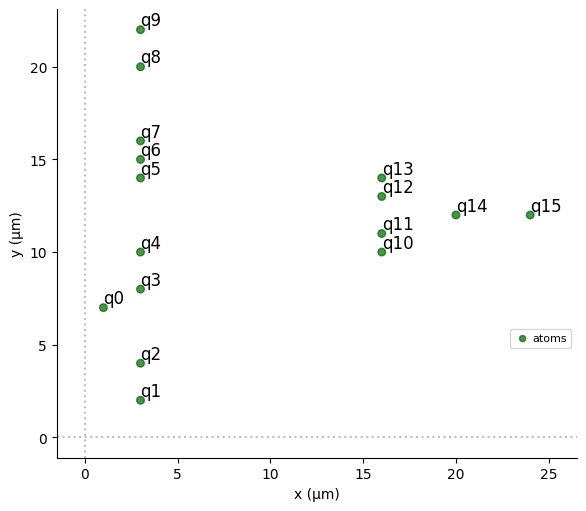

In [21]:
import math
import random
from collections import Counter
from typing import List, Tuple

# ──────────────────────────────────────────────────────────
#  Public helper
# ──────────────────────────────────────────────────────────
def generate_sierpinski_pixels(
    n: int,
    *,
    grid: int = 30,
    samples: int = 50_000,
    rng_seed: int | None = None,
) -> List[Tuple[int, int]]:
    """
    Return `n` integer grid-points giving a VERY low-res
    Sierpiński triangle (suitable for 10-20-pixel ‘pixel art’).

    Parameters
    ----------
    n : int               (#pixels you want, 10 ≤ n ≤ 20 recommended)
    grid : int            (grid resolution; 30 → coordinates ∈ [0..29])
    samples : int         (#chaos-game draws before binning)
    rng_seed : int | None (for reproducibility)

    Returns
    -------
    List[Tuple[int, int]] – (row, col) pairs on a `grid×grid` lattice
                             whose origin is the bottom-left corner
                             of the big (filled) triangle.
    """
    if not (1 <= n <= grid * grid):
        raise ValueError("n must be between 1 and grid²")

    rng = random.Random(rng_seed)

    # triangle vertices in unit coordinates
    v = ((0.0, 0.0), (1.0, 0.0), (0.5, math.sqrt(3) / 2))

    # -------- chaos game -------------
    x, y = 0.5, 0.25  # seed somewhere inside
    hits: Counter[Tuple[int, int]] = Counter()

    for _ in range(samples):
        vx, vy = rng.choice(v)
        x = (x + vx) / 2
        y = (y + vy) / 2
        # map (x,y) → discrete pixel indices
        col = int(x * (grid - 1) + 0.5)
        row = int(y * (grid - 1) + 0.5)
        hits[(row, col)] += 1

    # take the n cells with the most visits
    hottest = [cell for cell, _ in hits.most_common(n)]

    # optional: always include the apex pixel (topmost)
    apex = (grid - 1, grid // 2)
    if apex not in hottest and len(hottest) < n + 1:
        hottest.append(apex)

    # sort from bottom row upward for prettier order
    hottest.sort()
    return hottest


# ──────────────────────────────────────────────────────────
#  Quick demo
# ──────────────────────────────────────────────────────────
if __name__ == "__main__":
    pts = generate_sierpinski_pixels(15, grid=25, rng_seed=time.time())
    print(pts)          # → [(x0,y0), (x1,y1), …, (0.5, 0.8660254037844386)]
    scale = 1
    scaled_coords = [(x * scale, y * scale) for (x, y) in pts]
    qubits = {f"q{i}": coord for (i, coord) in enumerate(scaled_coords)}

    pasqalreg = Register(qubits)
    pasqalreg.draw(
        blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
        draw_graph=False,
        draw_half_radius=False,
    )


Classic: [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
Mod-2 Sierpiński: [(0, 0), (1, 0), (1, 1), (2, 0), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 4), (5, 0), (5, 1), (5, 4), (5, 5), (6, 0), (6, 2), (6, 4), (6, 6), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
[(0, 0), (1, 0), (1, 1), (2, 0), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 4)]


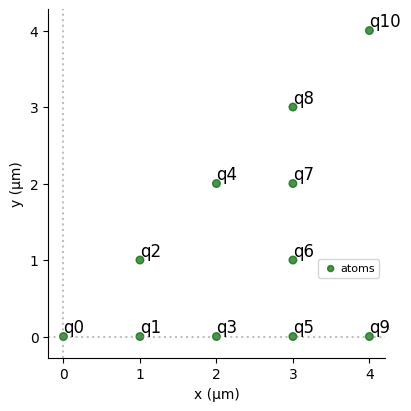

In [22]:
from typing import List, Tuple

# ──────────────────────────────────────────────────────────
#  Public helper
# ──────────────────────────────────────────────────────────
def pascal_triangle_coords(
    rows: int,
    *,
    mod2: bool = False,
) -> List[Tuple[int, int]]:
    """
    Return integer grid-coordinates for the first `rows` of Pascal’s triangle.

    Parameters
    ----------
    rows : int         (1 ≤ rows ≤ 60 is sensible for a quick run)
    mod2 : bool        • False → keep every non-zero entry
                       • True  → keep only entries that are odd
                                 (Pascal mod-2 ⇒ Sierpiński pattern)

    Returns
    -------
    List[Tuple[int, int]]
        Each tuple is (row, col) on a triangular lattice whose origin
        is the top of the triangle.  Row 0 has one entry at col 0.
    """
    if rows < 1:
        raise ValueError("rows must be ≥ 1")

    coords: List[Tuple[int, int]] = []
    row_vals = [1]

    for r in range(rows):
        # add coordinates that survive the mod-2 filter (if any)
        for c, v in enumerate(row_vals):
            if (v & 1) if mod2 else v:
                coords.append((r, c))
        # compute next row (in-place “add adjacent” trick)
        row_vals = [1] + [row_vals[i] + row_vals[i + 1] for i in range(len(row_vals) - 1)] + [1]

    return coords


# ──────────────────────────────────────────────────────────
#  Quick demos
# ──────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Classic Pascal triangle up to 6 rows  → 21 points
    pts = pascal_triangle_coords(6)
    print("Classic:", pascal_triangle_coords(6))

    # Pascal mod-2 up to 8 rows  → 16 ‘pixels’
    print("Mod-2 Sierpiński:", pascal_triangle_coords(8, mod2=True))
    pts = pascal_triangle_coords(5, mod2=True)
    print(pts)          # → [(x0,y0), (x1,y1), …, (0.5, 0.8660254037844386)]
    scale = 1
    scaled_coords = [(x * scale, y * scale) for (x, y) in pts]
    qubits = {f"q{i}": coord for (i, coord) in enumerate(scaled_coords)}

    pasqalreg = Register(qubits)
    pasqalreg.draw(
        blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
        draw_graph=False,
        draw_half_radius=False,
    )